In [1]:
import sys
sys.path.append("../")

from src.common_functions import *

In [2]:
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
import sys
import pandas as pd
from sklearn.metrics import roc_curve
import collections
from scipy.spatial import ConvexHull
from scipy.special import betainc
import scipy.special as ss

In [3]:
RAW_DATA_PATH = "../datasets/churn/e_commerce_churn.xlsx"
RAW_DATA_PATH = "C:/Users/stijn/OneDrive/Bureaublad/TEW 1ste jaar/python thesis/End-to-end-project---Customer-churn/datasets/churn/e_commerce_churn.xlsx"
DATASET_NAME = Path(RAW_DATA_PATH).stem
df = pd.read_excel(RAW_DATA_PATH, sheet_name="E Comm")
df = df.rename(columns=dict(
    zip(df.columns, list(map(to_snake_case, df.columns)))))

print(df.shape[0])
df.churn.value_counts()/df.shape[0]*100

5630


churn
0    83.161634
1    16.838366
Name: count, dtype: float64

In [4]:
df.isna().any()


customer_id                        False
churn                              False
tenure                              True
preferred_login_device             False
city_tier                          False
warehouse_to_home                   True
preferred_payment_mode             False
gender                             False
hour_spend_on_app                   True
number_of_device_registered        False
prefered_order_cat                 False
satisfaction_score                 False
marital_status                     False
number_of_address                  False
complain                           False
order_amount_hike_fromlast_year     True
coupon_used                         True
order_count                         True
day_since_last_order                True
cashback_amount                    False
dtype: bool

In [5]:
df.head(20
)

,customer_id,churn,tenure,preferred_login_device,city_tier,warehouse_to_home,preferred_payment_mode,gender,hour_spend_on_app,number_of_device_registered,prefered_order_cat,satisfaction_score,marital_status,number_of_address,complain,order_amount_hike_fromlast_year,coupon_used,order_count,day_since_last_order,cashback_amount
0,50001,1,4.0,Mobile Phone,3,6.0,Debit Card,Female,3.0,3,Laptop & Accessory,2,Single,9,1,11.0,1.0,1.0,5.0,159.93
1,50002,1,NaN,Phone,1,8.0,UPI,Male,3.0,4,Mobile,3,Single,7,1,15.0,0.0,1.0,0.0,120.90
2,50003,1,NaN,Phone,1,30.0,Debit Card,Male,2.0,4,Mobile,3,Single,6,1,14.0,0.0,1.0,3.0,120.28
3,50004,1,0.0,Phone,3,15.0,Debit Card,Male,2.0,4,Laptop & Accessory,5,Single,8,0,23.0,0.0,1.0,3.0,134.07
4,50005,1,0.0,Phone,1,12.0,CC,Male,NaN,3,Mobile,5,Single,3,0,11.0,1.0,1.0,3.0,129.60
5,50006,1,0.0,Computer,1,22.0,Debit Card,Female,3.0,5,Mobile Phone,5,Single,2,1,22.0,4.0,6.0,7.0,139.19
6,50007,1,NaN,Phone,3,11.0,Cash on Delivery,Male,2.0,3,Laptop & Accessory,2,Divorced,4,0,14.0,0.0,1.0,0.0,120.86
7,50008,1,NaN,Phone,1,6.0,CC,Male,3.0,3,Mobile,2,Divorced,3,1,16.0,2.0,2.0,0.0,122.93
8,50009,1,13.0,Phone,3,9.0,E wallet,Male,NaN,4,Mobile,3,Divorced,2,1,14.0,0.0,1.0,2.0,126.83
9,50010,1,NaN,Phone,1,31.0,Debit Card,Male,2.0,5,Mobile,3,Single,2,0,12.0,1.0,1.0,1.0,122.93


In [6]:
y = "churn"

# some generic cleaning

COLUMNS_TO_DROP = []
assert df[y].isna().any() == False
raw_features = df.drop(COLUMNS_TO_DROP, axis=1)

# ML tuning

train, test = train_test_split(
    raw_features, test_size=0.2, random_state=0, stratify=df[y])

fit_le = LabelEncoder().fit(train[y])

In [7]:
class_weights = compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(train['churn']),
                                        y = train['churn']                                                    
                                    )
class_weights = dict(zip(np.unique(train['churn']), class_weights))
class_weights

{0: 0.601174586225307, 1: 2.970976253298153}

In [8]:
param_grid = {
    'logistic__penalty': ['l2'],
    'logistic__C': [1, 10, 100, 1000],
    'pca__n_components': list(range(6, 32, 4)),
    # 'under__sampling_strategy': [0.1, 0.2, 0.3, 0.5, 0.7, 1],
    # 'over__sampling_strategy': [0.2, 0.3, 0.4, 0.5, 0.7, 1],
    'logistic__class_weight': [{0: 0.601174586225307, 1: 2.970976253298153}, {0:1,1:1}, {0:1,1:10}, {0:1,1:100}]
}

model = LogisticRegression()

MODEL_NAME = 'logistic'

grid = sklearn_gridsearch_using_pipeline(
    train, y_col_name=y, model=model, fit_le=fit_le, model_name='logistic', param_grid=param_grid, verbose = 1,step_names_to_remove=['under', 'over'])
best_pipeline_log_reg = grid.best_estimator_
best_pipeline_log_reg

Fitting 5 folds for each of 112 candidates, totalling 560 fits


Best score: 0.8913604103717236
Best parameters: {'logistic__C': 100, 'logistic__class_weight': {0: 1, 1: 1}, 'logistic__penalty': 'l2', 'pca__n_components': 30}


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('num_imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['customer_id', 'tenure',
                                                   'city_tier',
                                                   'warehouse_to_home',
                                                   'hour_spend_on_app',
                                                   'number_of_device_registered',
                                                   'satisfaction_score',
                                                   'number_of_address',
                                                   'complain',
                                                   'order_amount_hike_fromlas...
                                                   'day_since_last_order',
                                                   'cashback_amount']),
                                                 ('cat',
                                                  Pipeline(steps=[('cat_imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(sparse_output=False))]),
                                                  ['preferred_login_device',
                                                   'preferred_payment_mode',
                                                   'gender',
                                                   'prefered_order_cat',
                                                   'marital_status'])])),
                ('pca', PCA(n_components=30)),
                ('logistic',
                 LogisticRegression(C=100, class_weight={0: 1, 1: 1}))])

In [9]:
write_pipeline(best_pipeline_log_reg, MODEL_NAME, DATASET_NAME)

In [10]:
COLUMNS = ["pca__n_components", "logistic__class_weight", f"{MODEL_NAME}__C", f"{MODEL_NAME}__penalty", "roc_auc_mean", "roc_auc_std"]

pd.concat([
    pd.DataFrame(grid.cv_results_["params"]),
    pd.DataFrame(grid.cv_results_["mean_test_score"], columns=["roc_auc_mean"]),
    pd.DataFrame(grid.cv_results_["std_test_score"], columns=["roc_auc_std"])
    ],axis=1).dropna(subset=["roc_auc_mean", "roc_auc_std"])[COLUMNS] #.sort_values(by=COLUMNS)

,pca__n_components,logistic__class_weight,logistic__C,logistic__penalty,roc_auc_mean,roc_auc_std
0,6,"{0: 0.601174586225307, 1: 2.970976253298153}",1,l2,0.749292,0.016422
1,10,"{0: 0.601174586225307, 1: 2.970976253298153}",1,l2,0.842002,0.007640
2,14,"{0: 0.601174586225307, 1: 2.970976253298153}",1,l2,0.872792,0.017072
3,18,"{0: 0.601174586225307, 1: 2.970976253298153}",1,l2,0.877270,0.014714
4,22,"{0: 0.601174586225307, 1: 2.970976253298153}",1,l2,0.885078,0.012264
...,...,...,...,...,...,...
107,14,"{0: 1, 1: 100}",1000,l2,0.863416,0.017049
108,18,"{0: 1, 1: 100}",1000,l2,0.866921,0.014258
109,22,"{0: 1, 1: 100}",1000,l2,0.875938,0.012932
110,26,"{0: 1, 1: 100}",1000,l2,0.872813,0.013758


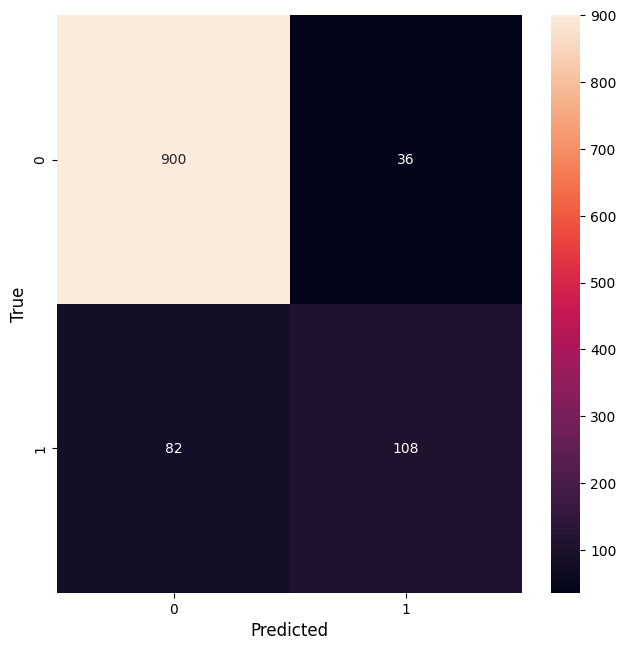

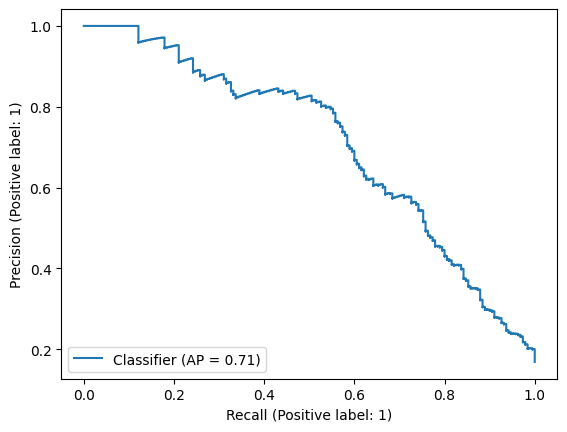

In [11]:
evaluate_model(best_pipeline_log_reg, fit_le=fit_le, test=test, y_col_name=y, model_name='logistic')

In [12]:
num_positive = np.sum(train == 1)
num_negative = np.sum(train == 0)
scale_pos_weight = num_negative / num_positive
print(scale_pos_weight)

customer_id                             NaN
churn                              4.941953
tenure                             0.780899
preferred_login_device                  NaN
city_tier                          0.000000
warehouse_to_home                       NaN
preferred_payment_mode                  NaN
gender                                  NaN
hour_spend_on_app                  0.115385
number_of_device_registered        0.000000
prefered_order_cat                      NaN
satisfaction_score                 0.000000
marital_status                          NaN
number_of_address                  0.000000
complain                           2.527016
order_amount_hike_fromlast_year         NaN
coupon_used                        0.496755
order_count                        0.000000
day_since_last_order               0.832990
cashback_amount                         inf
dtype: float64


In [13]:
param_grid_xgb = {
    'xgb__objective': ['binary:logistic'],
    'xgb__min_child_weight': [1, 5, 10],
    'xgb__gamma': [0.5, 1, 1.5, 2, 5],
    'xgb__subsample': [0.6, 0.8, 1.0],
    'xgb__colsample_bytree': [0.6, 0.8, 1.0],
    'xgb__max_depth': [3, 4, 5],
    'pca__n_components': [15, 20, 25,30,35,50,65],
    # 'under__sampling_strategy': [0.1, 0.2, 0.3, 0.5, 0.7, 1],
    # 'over__sampling_strategy': [0.2, 0.3, 0.4, 0.5, 0.7, 1]
    'xgb__scale_pos_weight':[ 1,4.941953 ,10, 50, 75, 100,175.735294,  1000]

}

xgb = XGBClassifier()

# xgb = XGBClassifier(scale_pos_weight=ratio)

MODEL_NAME = "xgb"

grid = sklearn_gridsearch_using_pipeline(
    train, y_col_name=y, fit_le=fit_le, model_name=MODEL_NAME, model=xgb, param_grid=param_grid_xgb, n_folds=5, verbose=1, randomized = True, step_names_to_remove=['under', 'over'])
best_pipeline_xgb = grid.best_estimator_
best_pipeline_xgb

Fitting 5 folds for each of 10 candidates, totalling 50 fits


c:\Users\stijn\.virtualenvs\End-to-end-project---Customer-churn-eLOWfj3z\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
20 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\stijn\.virtualenvs\End-to-end-project---Customer-churn-eLOWfj3z\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\stijn\.virtualenvs\End-to-end-project---Customer-churn-eLOWfj3z\Lib\site-packages\imblearn\pipeline.py", line 293, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
             ^^^^^^^^^^^^^

Best score: 0.9490847445717098
Best parameters: {'xgb__subsample': 1.0, 'xgb__scale_pos_weight': 1000, 'xgb__objective': 'binary:logistic', 'xgb__min_child_weight': 10, 'xgb__max_depth': 5, 'xgb__gamma': 5, 'xgb__colsample_bytree': 0.6, 'pca__n_components': 30}


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('num_imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['customer_id', 'tenure',
                                                   'city_tier',
                                                   'warehouse_to_home',
                                                   'hour_spend_on_app',
                                                   'number_of_device_registered',
                                                   'satisfaction_score',
                                                   'number_of_address',
                                                   'complain',
                                                   'order_amount_hike_fromlas...
                               feature_types=None, gamma=5, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=5, max_leaves=None,
                               min_child_weight=10, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=None, ...))])

In [14]:
write_pipeline(best_pipeline_xgb, MODEL_NAME, DATASET_NAME)

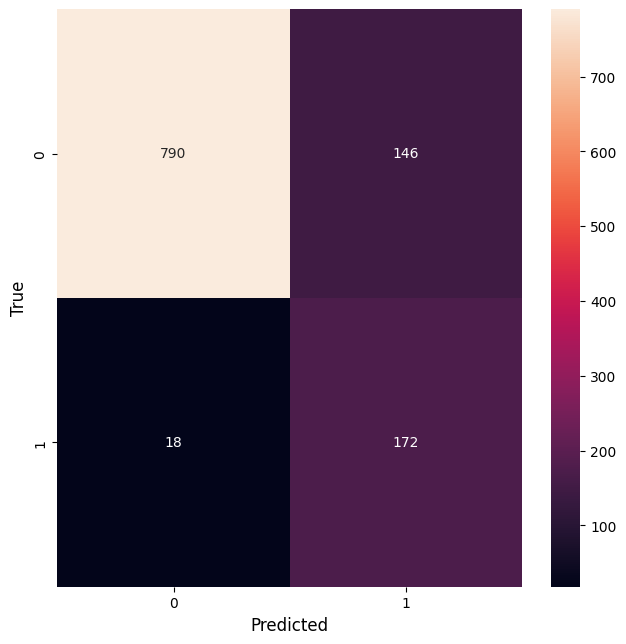

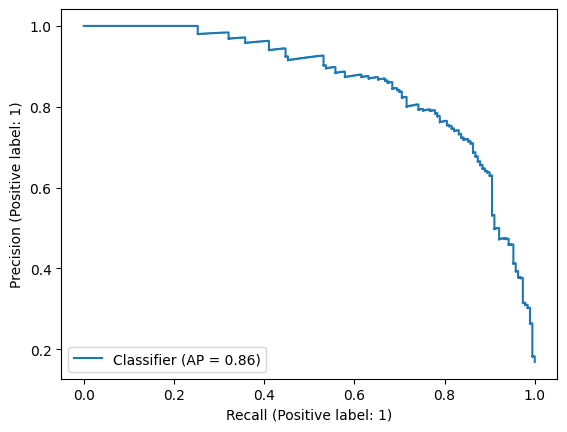

In [15]:
evaluate_model(best_pipeline_xgb, fit_le=fit_le, test=test, y_col_name=y, model_name=MODEL_NAME)

## Cost-based evaluation

In [16]:
MODEL_NAME='logistic'
best_pipeline_log_reg = load_pipeline(model_name=MODEL_NAME, dataset_name=DATASET_NAME)

MODEL_NAME='xgb'
best_pipeline_xgb = load_pipeline(model_name=MODEL_NAME, dataset_name=DATASET_NAME)

In [17]:

test_predictions_log = test.copy(deep=True)
test_predictions_log["y_predicted"] = best_pipeline_log_reg.predict(test_predictions_log.drop(y, axis=1))
test_predictions_log["churn_encoded"] = fit_le.transform(test_predictions_log["churn"])

# first check if customers have multiple rows => if so check if we can take other if this instance-based cost
impute = SimpleImputer(strategy='median')
test_predictions_log['A'] = impute.fit_transform(
    (test_predictions_log["order_count"]*test_predictions_log["tenure"]).to_frame())[:, 0]


# Step 3: Apply the function to calculate the cost for each instance and create the instance-dependent cost matrix
test_predictions_log['instance_cost'] = test_predictions_log.apply(lambda row: instance_dependent_cost_churn(
    row['y_predicted'], row["churn_encoded"], row["A"]), axis=1)

test_predictions_log["y_predicted_decoded"] = fit_le.inverse_transform(
    test_predictions_log["y_predicted"])

# Print the DataFrame with the instance-dependent cost matrix
test_predictions_log[['churn', 'y_predicted_decoded', "A", 'instance_cost']]

print(f"Test cost/loss = {test_predictions_log['instance_cost'].sum():.0f}.")
print(' total cost/loss average : ' , test_predictions_log['instance_cost'].sum()/len(test_predictions_log))

Test cost/loss = 23696.
 total cost/loss average :  21.044404973357015


In [18]:
print(test_predictions_log[['churn', 'A', 'instance_cost', "y_predicted"]].head())

      churn      A  instance_cost  y_predicted
2959      0  110.0            0.0            0
3157      0   88.0            0.0            0
2612      0    7.0            0.0            0
1463      0    9.0            0.0            0
5449      0   48.0            0.0            0


In [19]:

test_predictions_xgb = test.copy(deep=True)
test_predictions_xgb["y_predicted"] = best_pipeline_xgb.predict(test_predictions_xgb.drop(y, axis=1))
test_predictions_xgb["churn_encoded"] = fit_le.transform(test_predictions_xgb["churn"])

# first check if customers have multiple rows => if so check if we can take other if this instance-based cost
impute = SimpleImputer(strategy='median')
test_predictions_xgb['A'] = impute.fit_transform(
    (test_predictions_xgb["order_count"]*test_predictions_xgb["tenure"]).to_frame())[:, 0]


# Step 3: Apply the function to calculate the cost for each instance and create the instance-dependent cost matrix
test_predictions_xgb['instance_cost'] = test_predictions_xgb.apply(lambda row: instance_dependent_cost_churn(
    row['y_predicted'], row["churn_encoded"], row["A"]), axis=1)

test_predictions_xgb["y_predicted_decoded"] = fit_le.inverse_transform(
    test_predictions_xgb["y_predicted"])

# Print the DataFrame with the instance-dependent cost matrix
test_predictions_xgb[['churn', 'y_predicted_decoded', "A", 'instance_cost']]

print(f"Test cost/loss = {test_predictions_xgb['instance_cost'].sum():.0f}.")
print(' total cost/loss average : ' , test_predictions_xgb['instance_cost'].sum()/len(test_predictions_xgb))

Test cost/loss = 13562.
 total cost/loss average :  12.044404973357016


In [20]:
print(test_predictions_xgb[['churn', "A", 'instance_cost', 'y_predicted']].iloc[56:80])

      churn      A  instance_cost  y_predicted
4295      0   20.0            0.0            0
545       0    0.0            0.0            1
1937      0   60.0            0.0            0
4533      0    2.0            0.0            0
3202      0    2.0            4.0            1
1945      0   30.0            0.0            0
1103      0   14.0            0.0            0
5395      0   40.0            0.0            0
4763      0   38.0            0.0            0
3509      0    4.0            0.0            0
2457      1    1.0            0.0            1
4041      0  110.0            0.0            0
2027      0    5.0           10.0            1
2486      0   18.0            0.0            0
2443      0   26.0            0.0            0
3043      0   77.0            0.0            0
1788      1    0.0            0.0            1
1972      0   18.0            0.0            0
4725      0    2.0            0.0            0
4641      0   16.0            0.0            0
4241      0  

# 3.1 AMC metric

Decision Threshold: 0.01, Test cost/loss = 45696.00
Decision Threshold: 0.02, Test cost/loss = 42854.00
Decision Threshold: 0.03, Test cost/loss = 38410.00
Decision Threshold: 0.04, Test cost/loss = 35330.00


Decision Threshold: 0.05, Test cost/loss = 34520.00
Decision Threshold: 0.06, Test cost/loss = 33318.00
Decision Threshold: 0.07, Test cost/loss = 31954.00
Decision Threshold: 0.08, Test cost/loss = 30888.00
Decision Threshold: 0.09, Test cost/loss = 30632.00
Decision Threshold: 0.10, Test cost/loss = 29836.00
Decision Threshold: 0.11, Test cost/loss = 28846.00
Decision Threshold: 0.12, Test cost/loss = 29950.00
Decision Threshold: 0.13, Test cost/loss = 30018.00
Decision Threshold: 0.14, Test cost/loss = 29280.00
Decision Threshold: 0.15, Test cost/loss = 28536.00
Decision Threshold: 0.16, Test cost/loss = 26854.00
Decision Threshold: 0.17, Test cost/loss = 27260.00
Decision Threshold: 0.18, Test cost/loss = 26956.00
Decision Threshold: 0.19, Test cost/loss = 26374.00
Decision Threshold: 0.20, Test cost/loss = 25930.00
Decision Threshold: 0.21, Test cost/loss = 25796.00
Decision Threshold: 0.22, Test cost/loss = 25948.00
Decision Threshold: 0.23, Test cost/loss = 25792.00
Decision Thr

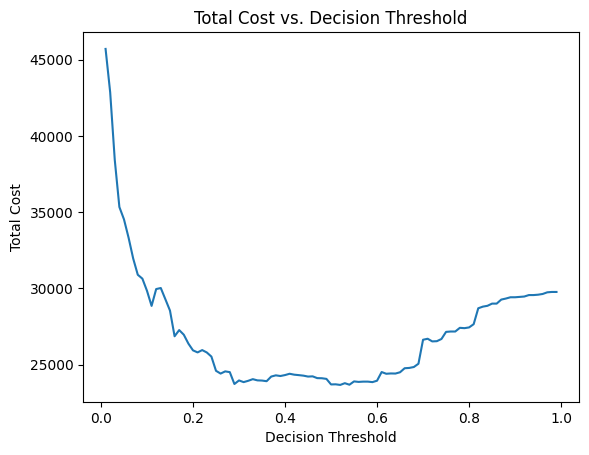

In [21]:
cb_column = 'A'
test_predictions_log['y_predicted_proba_log']= best_pipeline_log_reg.predict_proba(test_predictions_log.drop(y, axis=1))[:, 1]
best_threshold_log, AMC_log, lowest_cost_log = compute_best_threshold(test_predictions_log, best_pipeline_log_reg, y,cb_column, y_predicted_proba_col_name="y_predicted_proba_log")

Decision Threshold: 0.01, Test cost/loss = 26390.00
Decision Threshold: 0.02, Test cost/loss = 23686.00
Decision Threshold: 0.03, Test cost/loss = 22676.00
Decision Threshold: 0.04, Test cost/loss = 20944.00
Decision Threshold: 0.05, Test cost/loss = 19622.00
Decision Threshold: 0.06, Test cost/loss = 18902.00
Decision Threshold: 0.07, Test cost/loss = 18858.00
Decision Threshold: 0.08, Test cost/loss = 18728.00
Decision Threshold: 0.09, Test cost/loss = 18540.00
Decision Threshold: 0.10, Test cost/loss = 18256.00
Decision Threshold: 0.11, Test cost/loss = 17958.00
Decision Threshold: 0.12, Test cost/loss = 17958.00
Decision Threshold: 0.13, Test cost/loss = 17524.00
Decision Threshold: 0.14, Test cost/loss = 17662.00
Decision Threshold: 0.15, Test cost/loss = 17424.00
Decision Threshold: 0.16, Test cost/loss = 16890.00
Decision Threshold: 0.17, Test cost/loss = 16692.00
Decision Threshold: 0.18, Test cost/loss = 16052.00
Decision Threshold: 0.19, Test cost/loss = 16018.00
Decision Thr

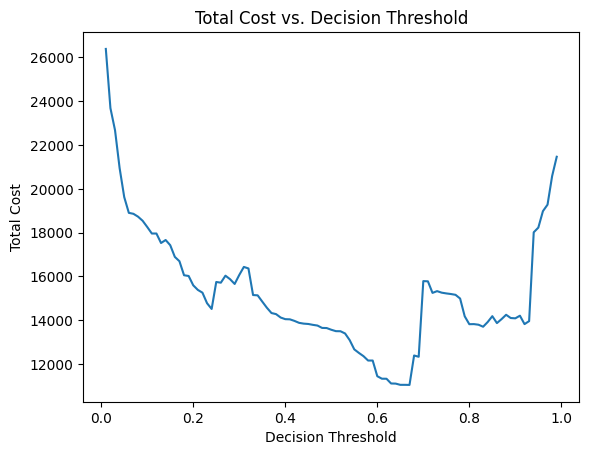

In [22]:
test_predictions_xgb['y_predicted_proba_xgb']= best_pipeline_xgb.predict_proba(test_predictions_xgb.drop(y, axis=1))[:, 1]
best_threshold_xgb, AMC_xgb, lowest_cost_xgb = compute_best_threshold(test_predictions_xgb, best_pipeline_xgb, y, cb_column, y_predicted_proba_col_name="y_predicted_proba_xgb")

# 3.2 E-AMC evaluation metric

In [23]:
test_predictions_log = add_eap_ep(
    train=train, 
    test=test_predictions_log, 
    y_col_name=y, 
    best_pipeline=best_pipeline_log_reg, 
    cb_column=cb_column, 
    predicted_proba_col_name='y_predicted_proba_log', 
    churn_label= 1, 
    instance_dependent_cost_type="churn")
test_predictions_xgb = add_eap_ep(
    train=train, 
    test=test_predictions_xgb, 
    y_col_name=y, 
    best_pipeline=best_pipeline_xgb, 
    cb_column=cb_column, 
    predicted_proba_col_name="y_predicted_proba_xgb", 
    churn_label=1, 
    instance_dependent_cost_type="churn")

c:\Users\stijn\OneDrive\Bureaublad\TEW 1ste jaar\python thesis\End-to-end-project---Customer-churn\notebooks\..\src\common_functions.py:329: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_actual_label_0['EAP'] = test_actual_label_0[predicted_proba_col_name]*test_actual_label_0['FP'] + \
c:\Users\stijn\OneDrive\Bureaublad\TEW 1ste jaar\python thesis\End-to-end-project---Customer-churn\notebooks\..\src\common_functions.py:331: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_actual_label_0['EP'] = estim

In [24]:
test_predictions_log

,customer_id,churn,tenure,preferred_login_device,city_tier,warehouse_to_home,preferred_payment_mode,gender,hour_spend_on_app,number_of_device_registered,...,A,instance_cost,y_predicted_decoded,y_predicted_proba_log,TN,FN,FP,TP,EAP,EP
2959,52960,0,10.0,Mobile Phone,1,13.0,Debit Card,Male,3.0,4,...,110.0,0.0,0,0.024657,0,1320.0,220.0,0,5.424434,37.024867
3157,53158,0,11.0,Computer,3,16.0,Credit Card,Male,4.0,4,...,88.0,0.0,0,0.133473,0,1056.0,176.0,0,23.491255,29.619893
2612,52613,0,7.0,Computer,3,16.0,Debit Card,Male,2.0,3,...,7.0,0.0,0,0.094349,0,84.0,14.0,0,1.320892,2.356128
1463,51464,0,9.0,Phone,1,9.0,Debit Card,Female,NaN,3,...,9.0,0.0,0,0.020253,0,108.0,18.0,0,0.364555,3.029307
5449,55450,0,12.0,Computer,2,9.0,UPI,Male,4.0,4,...,48.0,0.0,0,0.055146,0,576.0,96.0,0,5.294062,16.156306
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4774,54775,1,1.0,Computer,1,12.0,Credit Card,Female,3.0,5,...,2.0,24.0,0,0.388051,0,24.0,4.0,0,14.686768,19.960924
2827,52828,1,1.0,Mobile Phone,1,12.0,COD,Male,3.0,4,...,3.0,36.0,1,0.832776,0,36.0,6.0,0,6.020074,29.941385
531,50532,1,0.0,Phone,1,31.0,Debit Card,Male,NaN,3,...,0.0,0.0,1,0.818408,0,0.0,0.0,0,0.000000,0.000000
202,50203,1,2.0,Mobile Phone,3,9.0,Credit Card,Female,2.0,3,...,2.0,24.0,0,0.292363,0,24.0,4.0,0,16.983280,19.960924


In [25]:
test_predictions_xgb

,customer_id,churn,tenure,preferred_login_device,city_tier,warehouse_to_home,preferred_payment_mode,gender,hour_spend_on_app,number_of_device_registered,...,A,instance_cost,y_predicted_decoded,y_predicted_proba_xgb,TN,FN,FP,TP,EAP,EP
2959,52960,0,10.0,Mobile Phone,1,13.0,Debit Card,Male,3.0,4,...,110.0,0.0,0,0.003129,0,1320.0,220.0,0,0.688311,37.024867
3157,53158,0,11.0,Computer,3,16.0,Credit Card,Male,4.0,4,...,88.0,0.0,0,0.234757,0,1056.0,176.0,0,41.317202,29.619893
2612,52613,0,7.0,Computer,3,16.0,Debit Card,Male,2.0,3,...,7.0,0.0,0,0.066382,0,84.0,14.0,0,0.929342,2.356128
1463,51464,0,9.0,Phone,1,9.0,Debit Card,Female,NaN,3,...,9.0,0.0,0,0.000278,0,108.0,18.0,0,0.004996,3.029307
5449,55450,0,12.0,Computer,2,9.0,UPI,Male,4.0,4,...,48.0,0.0,0,0.003641,0,576.0,96.0,0,0.349519,16.156306
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4774,54775,1,1.0,Computer,1,12.0,Credit Card,Female,3.0,5,...,2.0,24.0,1,0.950333,0,24.0,4.0,0,1.192007,19.960924
2827,52828,1,1.0,Mobile Phone,1,12.0,COD,Male,3.0,4,...,3.0,0.0,1,0.999538,0,36.0,6.0,0,0.016647,29.941385
531,50532,1,0.0,Phone,1,31.0,Debit Card,Male,NaN,3,...,0.0,0.0,1,0.996248,0,0.0,0.0,0,0.000000,0.000000
202,50203,1,2.0,Mobile Phone,3,9.0,Credit Card,Female,2.0,3,...,2.0,0.0,1,0.995496,0,24.0,4.0,0,0.108089,19.960924


In [26]:
print(test_predictions_log['EAP'].sum())
print(test_predictions_log['EP'].sum())


print('EAP : ', test_predictions_log['EAP'].sum()/len(test_predictions_log))
print('EP : ', test_predictions_log['EP'].sum()/len(test_predictions_log))

27209.782190044487
37086.21136767318
EAP :  24.16499306398267
EP :  32.936244553883824


In [27]:
print(test_predictions_xgb['EAP'].sum())
print(test_predictions_xgb['EP'].sum())


print('EAP : ', test_predictions_xgb['EAP'].sum()/len(test_predictions_xgb))
print('EP : ', test_predictions_xgb['EP'].sum()/len(test_predictions_xgb))

15436.715883897092
37086.21136767318
EAP :  13.709339150885517
EP :  32.936244553883824


# 3.3: MP metric

In [28]:
test_predictions_log_2 = test.copy(deep=True)
test_predictions_log_2["y_predicted"] = best_pipeline_log_reg.predict(test_predictions_log_2.drop(y, axis=1))
test_predictions_log_2["churn_encoded"] = fit_le.transform(test_predictions_log_2["churn"])

# first check if customers have multiple rows => if so check if we can take other if this instance-based cost
impute = SimpleImputer(strategy='median')
test_predictions_log_2['A'] = impute.fit_transform(
    (test_predictions_log_2["order_count"]*test_predictions_log_2["tenure"]).to_frame())[:, 0]


# Step 3: Apply the function to calculate the cost for each instance and create the instance-dependent cost matrix
test_predictions_log_2['instance_cost'] = test_predictions_log_2.apply(lambda row: instance_dependent_cost_churn_2(
    row['y_predicted'], row["churn_encoded"], row["A"]), axis=1)

test_predictions_log_2["y_predicted_decoded"] = fit_le.inverse_transform(
    test_predictions_log_2["y_predicted"])

# Print the DataFrame with the instance-dependent cost matrix
test_predictions_log_2[['churn', 'y_predicted_decoded', "A", 'instance_cost']]

print(f"Test cost/loss = {test_predictions_log_2['instance_cost'].sum():.0f}.")
print(' total cost/loss average : ' , test_predictions_log_2['instance_cost'].sum()/len(test_predictions_log_2))

Test cost/loss = -22530.
 total cost/loss average :  -20.008880994671404


In [29]:
test_predictions_xgb_2 = test.copy(deep=True)
test_predictions_xgb_2["y_predicted"] = best_pipeline_xgb.predict(test_predictions_xgb_2.drop(y, axis=1))
test_predictions_xgb_2["churn_encoded"] = fit_le.transform(test_predictions_xgb_2["churn"])

# First check if customers have multiple rows => if so check if we can take other if this instance-based cost
impute = SimpleImputer(strategy='median')
test_predictions_xgb_2['A'] = impute.fit_transform(
    (test_predictions_xgb_2["order_count"]*test_predictions_xgb_2["tenure"]).to_frame())[:, 0]

# Step 3: Apply the function to calculate the cost for each instance and create the instance-dependent cost matrix
test_predictions_xgb_2['instance_cost'] = test_predictions_xgb_2.apply(lambda row: instance_dependent_cost_churn_2(
    row['y_predicted'], row["churn_encoded"], row["A"]), axis=1)

test_predictions_xgb_2["y_predicted_decoded"] = fit_le.inverse_transform(
    test_predictions_xgb_2["y_predicted"])

# Print the DataFrame with the instance-dependent cost matrix
test_predictions_xgb_2[['churn', 'y_predicted_decoded', "A", 'instance_cost']]

print(f"Test cost/loss = {test_predictions_xgb_2['instance_cost'].sum():.0f}.")
print(' total cost/loss average : ' , test_predictions_xgb_2['instance_cost'].sum()/len(test_predictions_xgb_2))

Test cost/loss = -9504.
 total cost/loss average :  -8.440497335701599


# MP-metric

Decision Threshold: 0.01, Test cost/loss = -41712.00
Decision Threshold: 0.02, Test cost/loss = -39864.00
Decision Threshold: 0.03, Test cost/loss = -35482.00
Decision Threshold: 0.04, Test cost/loss = -32492.00
Decision Threshold: 0.05, Test cost/loss = -32068.00
Decision Threshold: 0.06, Test cost/loss = -30938.00
Decision Threshold: 0.07, Test cost/loss = -29574.00
Decision Threshold: 0.08, Test cost/loss = -28564.00


Decision Threshold: 0.09, Test cost/loss = -28460.00
Decision Threshold: 0.10, Test cost/loss = -27664.00
Decision Threshold: 0.11, Test cost/loss = -26674.00
Decision Threshold: 0.12, Test cost/loss = -28030.00
Decision Threshold: 0.13, Test cost/loss = -28184.00
Decision Threshold: 0.14, Test cost/loss = -27458.00
Decision Threshold: 0.15, Test cost/loss = -26750.00
Decision Threshold: 0.16, Test cost/loss = -25104.00
Decision Threshold: 0.17, Test cost/loss = -25630.00
Decision Threshold: 0.18, Test cost/loss = -25382.00
Decision Threshold: 0.19, Test cost/loss = -24840.00
Decision Threshold: 0.20, Test cost/loss = -24404.00
Decision Threshold: 0.21, Test cost/loss = -24270.00
Decision Threshold: 0.22, Test cost/loss = -24464.00
Decision Threshold: 0.23, Test cost/loss = -24308.00
Decision Threshold: 0.24, Test cost/loss = -24042.00
Decision Threshold: 0.25, Test cost/loss = -23110.00
Decision Threshold: 0.26, Test cost/loss = -22928.00
Decision Threshold: 0.27, Test cost/loss = -23

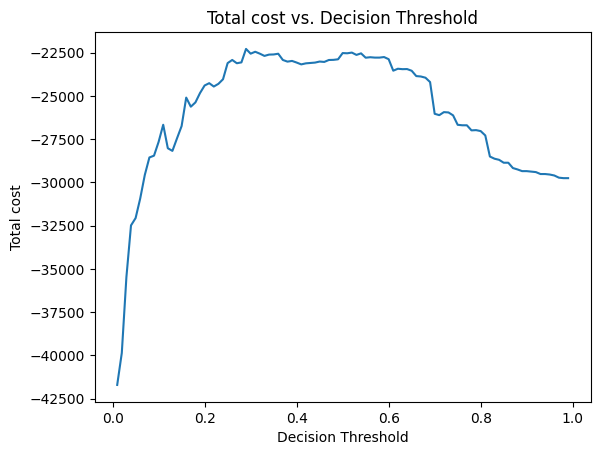

In [30]:
cb_column = 'A'
test_predictions_log_2['y_predicted_proba_log']= best_pipeline_log_reg.predict_proba(test_predictions_log_2.drop(y, axis=1))[:, 1]
best_threshold_log, AMC_log, lowest_cost_log = compute_best_threshold_2(test_predictions_log_2, best_pipeline_log_reg, y,cb_column, y_predicted_proba_col_name="y_predicted_proba_log", instance_dependent_cost_type= 'churn_2' )

Decision Threshold: 0.01, Test cost/loss = -21458.00
Decision Threshold: 0.02, Test cost/loss = -18944.00
Decision Threshold: 0.03, Test cost/loss = -17934.00
Decision Threshold: 0.04, Test cost/loss = -16202.00
Decision Threshold: 0.05, Test cost/loss = -14880.00
Decision Threshold: 0.06, Test cost/loss = -14160.00
Decision Threshold: 0.07, Test cost/loss = -14236.00
Decision Threshold: 0.08, Test cost/loss = -14106.00
Decision Threshold: 0.09, Test cost/loss = -13918.00
Decision Threshold: 0.10, Test cost/loss = -13670.00
Decision Threshold: 0.11, Test cost/loss = -13372.00
Decision Threshold: 0.12, Test cost/loss = -13372.00
Decision Threshold: 0.13, Test cost/loss = -12938.00
Decision Threshold: 0.14, Test cost/loss = -13148.00
Decision Threshold: 0.15, Test cost/loss = -12910.00
Decision Threshold: 0.16, Test cost/loss = -12376.00
Decision Threshold: 0.17, Test cost/loss = -12178.00
Decision Threshold: 0.18, Test cost/loss = -11538.00
Decision Threshold: 0.19, Test cost/loss = -11

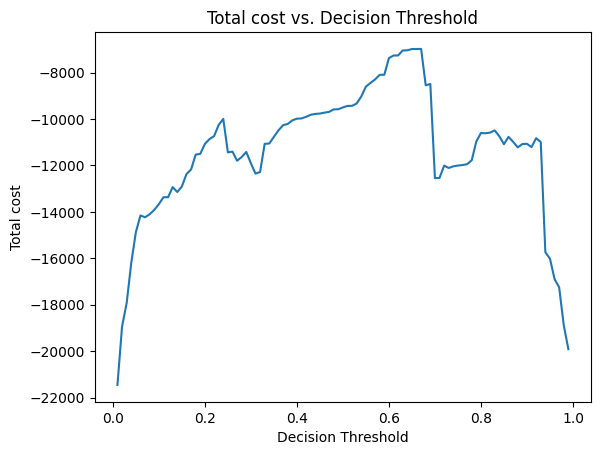

In [31]:
test_predictions_xgb_2['y_predicted_proba_xgb']= best_pipeline_xgb.predict_proba(test_predictions_xgb_2.drop(y, axis=1))[:, 1]
best_threshold_xgb, AMC_xgb, lowest_cost_xgb = compute_best_threshold_2(test_predictions_xgb_2, best_pipeline_xgb, y, cb_column, y_predicted_proba_col_name="y_predicted_proba_xgb", instance_dependent_cost_type= 'churn_2')

# EMP-metric

In [32]:
test_predictions_log_2 = add_eap_ep(
    train=train, 
    test=test_predictions_log_2, 
    y_col_name=y, 
    best_pipeline=best_pipeline_log_reg, 
    cb_column=cb_column, 
    predicted_proba_col_name='y_predicted_proba_log', 
    churn_label= 1, 
    instance_dependent_cost_type="churn_2")
test_predictions_xgb_2 = add_eap_ep(
    train=train, 
    test=test_predictions_xgb_2, 
    y_col_name=y, 
    best_pipeline=best_pipeline_xgb, 
    cb_column=cb_column, 
    predicted_proba_col_name="y_predicted_proba_xgb", 
    churn_label=1, 
    instance_dependent_cost_type="churn_2")

c:\Users\stijn\OneDrive\Bureaublad\TEW 1ste jaar\python thesis\End-to-end-project---Customer-churn\notebooks\..\src\common_functions.py:329: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_actual_label_0['EAP'] = test_actual_label_0[predicted_proba_col_name]*test_actual_label_0['FP'] + \
c:\Users\stijn\OneDrive\Bureaublad\TEW 1ste jaar\python thesis\End-to-end-project---Customer-churn\notebooks\..\src\common_functions.py:331: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_actual_label_0['EP'] = estim

In [33]:
print(test_predictions_log_2['EAP'].sum())
print(test_predictions_log_2['EP'].sum())


print('EAP : ', test_predictions_log_2['EAP'].sum()/len(test_predictions_log_2))
print('EP : ', test_predictions_log_2['EP'].sum()/len(test_predictions_log_2))

-26080.571045934073
-36251.46891651865
EAP :  -23.162141248609302
EP :  -32.19491022781408


In [34]:
print(test_predictions_xgb_2['EAP'].sum())
print(test_predictions_xgb_2['EP'].sum())


print('EAP : ', test_predictions_xgb_2['EAP'].sum()/len(test_predictions_xgb_2))
print('EP : ', test_predictions_xgb_2['EP'].sum()/len(test_predictions_xgb_2))

-11598.52489941794
-36251.46891651865
EAP :  -10.300643782786803
EP :  -32.19491022781408


# mp and emp metric non instance based (extra, outside of the scope)

In [35]:
df['cashback_amount'].mean()

177.22303019538188

In [36]:
test_predictions_log3 = test.copy(deep=True)
test_predictions_log3["y_predicted_proba"] = best_pipeline_log_reg.predict_proba(test_predictions_log3.drop(y, axis=1))[:, 1]
test_predictions_log3["churn_encoded"] = fit_le.transform(test_predictions_log3["churn"])
def __empRocInfo(probability_scores, true_class_labels):
    
    # test['y_predicted_proba'] =  log_best.predict_proba(test.drop(y_encoded_col_name, axis=1))[:, 1]

    
    arguments_list = [test_predictions_log3['y_predicted_proba'], test_predictions_log3["churn_encoded"]]
    factor_array = []
    n_0 = 0
    number_of_factors = 0
    
    def linear_line(m, x, b):
        return m*x + b
    
    
    for i in range(0, len(arguments_list)):
        if (type(arguments_list[i]) == pd.Series):
            arguments_list[i] = arguments_list[i].to_numpy().reshape(1,-1)[0]
        if (type(arguments_list[i]) == np.matrix):
            arguments_list[i] = np.asarray(arguments_list[i]).reshape(1,-1)[0]
        if (type(arguments_list[i]) == list):
            arguments_list[i] = np.array(arguments_list[i]).reshape(1,-1)[0]
    
    for i in range(0, len(arguments_list[1])):
        if (arguments_list[1][i] not in factor_array):
            factor_array.append(arguments_list[1][i])
            number_of_factors = number_of_factors + 1
            
    if (number_of_factors > 2):
        sys.exit("More than 2 classes in true class labels, data not suitable for binary classification")


    ### Checking to ensure that the probability scores array is the same length as the true class labels array ###

    if (len(arguments_list[0]) != len(arguments_list[1])):
        sys.exit("Length of input arrays probability_scores and true_class_labels are not equal")

### Checking that there are no invalid probabilities in the probability scores array ###

    for i in range(0, len(arguments_list[0])):
        if (arguments_list[0][i] > 1 or arguments_list[0][i] < 0):
            sys.exit("Invalid Probability Score: You have a probability outside [0,1]")

### Counting the number of positive cases in the true class values array ###

    for i in range(0, len(arguments_list[1])):
        if (arguments_list[1][i] == 1):
            n_0 +=  1
            
### Calculating metrics ###

    total_number_of_observations = len(arguments_list[1])
    n_1 = total_number_of_observations - n_0
    pi_1 = n_1 / total_number_of_observations
    pi_0 = n_0 / total_number_of_observations
    fpr, tpr, thresholds = roc_curve(arguments_list[1], arguments_list[0])
    roc_output = np.c_[fpr, tpr]
    hull = ConvexHull(roc_output)
    vertices = []
    
    for k in hull.vertices:
        if roc_output[k,1] >= linear_line(1, roc_output[k,0], 0):
            vertices.append(k)
            
    F_1 = roc_output[vertices, 0]
    F_1 = np.sort(F_1)
    F_0 = roc_output[vertices, 1]
    F_0 = np.sort(F_0)
    
    return n_0, n_1, pi_0, pi_1, F_0, F_1











In [37]:

# test_predictions = test.copy(deep=True)
# test_predictions["y_predicted_proba"] = best_pipeline_log_reg.predict_proba(test_predictions.drop(y, axis=1))[:, 1]
# test_predictions["churn_encoded"] = fit_le.transform(test_predictions["churn"])

def empChurn(probability_scores, true_class_labels, alpha=6, beta=14, clv=177.22, d=10, f=1, print_output=False, return_output=True, rounding=None):
     
     
    def B(a, b, X):
        
        
        return betainc(a, b, X)* ss.beta(a, b)

        ### Initializing constants and variables for rest of function ###

    roc = __empRocInfo(test_predictions_log3["y_predicted_proba"], test_predictions_log3["churn_encoded"])
    E_GAMMA = alpha / (alpha + beta)
    DELTA = d / clv
    PHI = f / clv
        
    ### Calculating MP and MP fraction ###
    '''
    n_0, n_1, pi_0, pi_1, F_0, F_1
    gamma values = pi_0 (delta * phi)
    '''
    gamma_values = np.append(0, (roc[3]*(DELTA + PHI)*np.diff(roc[5]) + roc[2]*PHI*np.diff(roc[4])) / (roc[2]*(1 - DELTA)*np.diff(roc[4])))
    gamma_values = np.append(gamma_values[gamma_values < 1], 1)
    ind_E = np.max(np.where((gamma_values < E_GAMMA) == True))
    MP = clv*((E_GAMMA*(1 - DELTA) - PHI)*roc[2]*(roc[4])[ind_E] - (DELTA + PHI)*roc[3]*(roc[5])[ind_E])
    MP_fraction = roc[2]*(roc[4])[ind_E] + roc[3]*(roc[5])[ind_E]

    ### Calculating EMP and EMP fraction ###

    gammaii = gamma_values[range(0, len(gamma_values) - 1)]
    gammaie = gamma_values[range(1, len(gamma_values))]
    F_0 = (roc[4])[range(0, len(gammaii))]
    F_1 = (roc[5])[range(0, len(gammaii))]
    contr_0 = (clv*(1 - DELTA)*roc[2]*F_0)*(B(alpha + 1, beta, gammaie) - B(alpha + 1, beta, gammaii)) / B(alpha, beta, 1)
    contr_1 = (-clv*(PHI*roc[2]*F_0 + (DELTA + PHI)*roc[3]*F_1))*(B(alpha, beta, gammaie) - B(alpha, beta, gammaii)) / B(alpha, beta, 1)
    EMP = np.sum(contr_0 + contr_1)
    EMP_fraction = np.matmul((((B(alpha, beta, gammaie) - B(alpha, beta, gammaii)) / B(alpha, beta, 1)).T), (roc[2]*F_0 + roc[3]*F_1))

    ### Formatting output ###

    if rounding != None:
        MP = np.round(MP, decimals = rounding)
        MP_fraction = np.round(MP_fraction, decimals = rounding)
        EMP = np.round(EMP, decimals = rounding)
        EMP_fraction = np.round(EMP_fraction, decimals = rounding)
        

        
    output = collections.namedtuple('output',['MP','MP_fraction','EMP', 'EMP_fraction'])
    output = output(MP, MP_fraction, EMP, EMP_fraction)
        
    if print_output:
        print("******************************************************************************")
        print("EMP Churn Output")
        print("******************************************************************************")
        print("MP: ", MP)
        print("")
        print("MP Fraction: ", MP_fraction)
        print("")
        print("EMP: ", EMP)
        print("")
        print("EMP Fraction: ", EMP_fraction)

    
            
    if return_output:
        return output

empChurn(test_predictions_log3["y_predicted_proba"], test_predictions_log3["churn_encoded"], alpha=6, beta=14, clv=177.22, d=10, f=1, print_output=False, return_output=True, rounding=None)


C:\Users\stijn\AppData\Local\Temp\ipykernel_4352\596991683.py:25: RuntimeWarning: divide by zero encountered in divide
  gamma_values = np.append(0, (roc[3]*(DELTA + PHI)*np.diff(roc[5]) + roc[2]*PHI*np.diff(roc[4])) / (roc[2]*(1 - DELTA)*np.diff(roc[4])))


output(MP=5.072296625222024, MP_fraction=0.22380106571936056, EMP=5.1055150740022714, EMP_fraction=0.2275185409701374)

In [38]:
test_predictions_xgb_3 = test.copy(deep=True)
test_predictions_xgb_3["y_predicted_proba"] = best_pipeline_xgb.predict_proba(test_predictions_xgb_3.drop(y, axis=1))[:, 1]
test_predictions_xgb_3["churn_encoded"] = fit_le.transform(test_predictions_xgb_3["churn"])
def __empRocInfo(probability_scores, true_class_labels):
    
    # test['y_predicted_proba'] =  log_best.predict_proba(test.drop(y_encoded_col_name, axis=1))[:, 1]

    
    arguments_list = [test_predictions_xgb_3['y_predicted_proba'], test_predictions_xgb_3["churn_encoded"]]
    factor_array = []
    n_0 = 0
    number_of_factors = 0
    
    def linear_line(m, x, b):
        return m*x + b
    
    
    for i in range(0, len(arguments_list)):
        if (type(arguments_list[i]) == pd.Series):
            arguments_list[i] = arguments_list[i].to_numpy().reshape(1,-1)[0]
        if (type(arguments_list[i]) == np.matrix):
            arguments_list[i] = np.asarray(arguments_list[i]).reshape(1,-1)[0]
        if (type(arguments_list[i]) == list):
            arguments_list[i] = np.array(arguments_list[i]).reshape(1,-1)[0]
    
    for i in range(0, len(arguments_list[1])):
        if (arguments_list[1][i] not in factor_array):
            factor_array.append(arguments_list[1][i])
            number_of_factors = number_of_factors + 1
            
    if (number_of_factors > 2):
        sys.exit("More than 2 classes in true class labels, data not suitable for binary classification")


    ### Checking to ensure that the probability scores array is the same length as the true class labels array ###

    if (len(arguments_list[0]) != len(arguments_list[1])):
        sys.exit("Length of input arrays probability_scores and true_class_labels are not equal")

### Checking that there are no invalid probabilities in the probability scores array ###

    for i in range(0, len(arguments_list[0])):
        if (arguments_list[0][i] > 1 or arguments_list[0][i] < 0):
            sys.exit("Invalid Probability Score: You have a probability outside [0,1]")

### Counting the number of positive cases in the true class values array ###

    for i in range(0, len(arguments_list[1])):
        if (arguments_list[1][i] == 1):
            n_0 +=  1
            
### Calculating metrics ###

    total_number_of_observations = len(arguments_list[1])
    n_1 = total_number_of_observations - n_0
    pi_1 = n_1 / total_number_of_observations
    pi_0 = n_0 / total_number_of_observations
    fpr, tpr, thresholds = roc_curve(arguments_list[1], arguments_list[0])
    roc_output = np.c_[fpr, tpr]
    hull = ConvexHull(roc_output)
    vertices = []
    
    for k in hull.vertices:
        if roc_output[k,1] >= linear_line(1, roc_output[k,0], 0):
            vertices.append(k)
            
    F_1 = roc_output[vertices, 0]
    F_1 = np.sort(F_1)
    F_0 = roc_output[vertices, 1]
    F_0 = np.sort(F_0)
    
    return n_0, n_1, pi_0, pi_1, F_0, F_1






In [39]:
test_predictions_xgb_3 = test.copy(deep=True)
test_predictions_xgb_3["y_predicted_proba"] = best_pipeline_xgb.predict_proba(test_predictions_xgb_3.drop(y, axis=1))[:, 1]
test_predictions_xgb_3["churn_encoded"] = fit_le.transform(test_predictions_xgb_3["churn"])

def empChurn(probability_scores, true_class_labels, alpha=6, beta=14, clv=177.22, d=10, f=1, print_output=False, return_output=True, rounding=None):
     
     
    def B(a, b, X):
        
        
        return betainc(a, b, X)* ss.beta(a, b)

        ### Initializing constants and variables for rest of function ###

    roc = __empRocInfo(test_predictions_xgb_3["y_predicted_proba"], test_predictions_xgb_3["churn_encoded"])
    E_GAMMA = alpha / (alpha + beta)
    DELTA = d / clv
    PHI = f / clv
        
    ### Calculating MP and MP fraction ###
    '''
    n_0, n_1, pi_0, pi_1, F_0, F_1
    gamma values = pi_0 (delta * phi)
    '''
    gamma_values = np.append(0, (roc[3]*(DELTA + PHI)*np.diff(roc[5]) + roc[2]*PHI*np.diff(roc[4])) / (roc[2]*(1 - DELTA)*np.diff(roc[4])))
    gamma_values = np.append(gamma_values[gamma_values < 1], 1)
    ind_E = np.max(np.where((gamma_values < E_GAMMA) == True))
    MP = clv*((E_GAMMA*(1 - DELTA) - PHI)*roc[2]*(roc[4])[ind_E] - (DELTA + PHI)*roc[3]*(roc[5])[ind_E])
    MP_fraction = roc[2]*(roc[4])[ind_E] + roc[3]*(roc[5])[ind_E]

    ### Calculating EMP and EMP fraction ###

    gammaii = gamma_values[range(0, len(gamma_values) - 1)]
    gammaie = gamma_values[range(1, len(gamma_values))]
    F_0 = (roc[4])[range(0, len(gammaii))]
    F_1 = (roc[5])[range(0, len(gammaii))]
    contr_0 = (clv*(1 - DELTA)*roc[2]*F_0)*(B(alpha + 1, beta, gammaie) - B(alpha + 1, beta, gammaii)) / B(alpha, beta, 1)
    contr_1 = (-clv*(PHI*roc[2]*F_0 + (DELTA + PHI)*roc[3]*F_1))*(B(alpha, beta, gammaie) - B(alpha, beta, gammaii)) / B(alpha, beta, 1)
    EMP = np.sum(contr_0 + contr_1)
    EMP_fraction = np.matmul((((B(alpha, beta, gammaie) - B(alpha, beta, gammaii)) / B(alpha, beta, 1)).T), (roc[2]*F_0 + roc[3]*F_1))

    ### Formatting output ###

    if rounding != None:
        MP = np.round(MP, decimals = rounding)
        MP_fraction = np.round(MP_fraction, decimals = rounding)
        EMP = np.round(EMP, decimals = rounding)
        EMP_fraction = np.round(EMP_fraction, decimals = rounding)
        

        
    output = collections.namedtuple('output',['MP','MP_fraction','EMP', 'EMP_fraction'])
    output = output(MP, MP_fraction, EMP, EMP_fraction)
        
    if print_output:
        print("******************************************************************************")
        print("EMP Churn Output")
        print("******************************************************************************")
        print("MP: ", MP)
        print("")
        print("MP Fraction: ", MP_fraction)
        print("")
        print("EMP: ", EMP)
        print("")
        print("EMP Fraction: ", EMP_fraction)

    
            
    if return_output:
        return output

empChurn(test_predictions_xgb_3["y_predicted_proba"], test_predictions_xgb_3["churn_encoded"], alpha=6, beta=14, clv=177.22, d=10, f=1, print_output=False, return_output=True, rounding=None)


C:\Users\stijn\AppData\Local\Temp\ipykernel_4352\1535038434.py:25: RuntimeWarning: divide by zero encountered in divide
  gamma_values = np.append(0, (roc[3]*(DELTA + PHI)*np.diff(roc[5]) + roc[2]*PHI*np.diff(roc[4])) / (roc[2]*(1 - DELTA)*np.diff(roc[4])))


output(MP=6.523580817051509, MP_fraction=0.2424511545293073, EMP=6.564106138174877, EMP_fraction=0.22393773504597253)

# cost curves

In [40]:
test_predictions_log['FP']

2959    220.0
3157    176.0
2612     14.0
1463     18.0
5449     96.0
        ...  
4774      4.0
2827      6.0
531       0.0
202       4.0
1579      0.0
Name: FP, Length: 1126, dtype: float64

In [41]:
len(test_predictions_log['FP'])

1126

In [42]:
total_fp_log = 0

for i in range(0,1126):
    if test_predictions_log['churn_encoded'].iloc[i] == 0 and test_predictions_log['y_predicted'].iloc[i]==1:
        total_fp_log += test_predictions_log['FP'].iloc[i]
    else:
        total_fp_log += 0

print(total_fp_log)

average_fp_log = total_fp_log/1126
print( average_fp_log)

932.0
0.827708703374778


In [43]:
total_fn_log = 0

for i in range(0,1126):
    if test_predictions_log['churn_encoded'].iloc[i] == 1 and test_predictions_log['y_predicted'].iloc[i]==0:
        total_fn_log += test_predictions_log['FN'].iloc[i]
    else:
        total_fn_log += 0

print(total_fn_log)

average_fn_log = total_fn_log/1126
print( average_fn_log)

22764.0
20.216696269982236


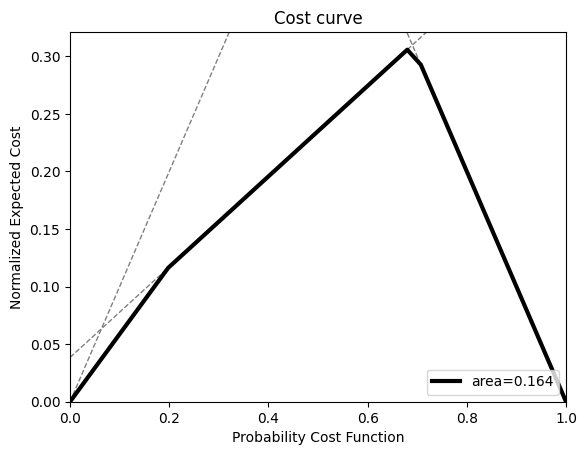

In [44]:
# C(-|+)
cost_fn_log = average_fn_log
# C(+|-)
cost_fp_log = average_fp_log

# Ground truth
truth = test_predictions_log['churn_encoded']
#  <a list of 0 (negative class) or 1 (positive class)>
# Predictions from a classifier
score = test_predictions_log['y_predicted']
# best_pipeline_log_reg.predict_proba(test.drop(y_encoded_col_name, axis=1))[:, 1]
# <a list of [0,1] class probabilities>

# %% OUTPUTS

# 1D-array of x-axis values (normalized PC)
pc = None
# list of lines as (slope, intercept)
lines = []
# lower envelope of the list of lines as a 1D-array of y-axis values (NEC)
lower_envelope = []
# area under the lower envelope (the smaller, the better)
area = None

# %% COMPUTATION

# points from the roc curve, because a point in the ROC space <=> a line in the cost space
roc_fpr, roc_tpr, _ = roc_curve(truth, score)

# compute the normalized p(+)*C(-|+)
thresholds = np.arange(0, 1.01, .01)
pc = (thresholds*cost_fn_log) / (thresholds*cost_fn_log + (1-thresholds)*cost_fp_log)

# compute a line in the cost space for each point in the roc space
for fpr, tpr in zip(roc_fpr, roc_tpr):
    slope = (1-tpr-fpr)
    intercept = fpr
    lines.append((slope, intercept))

# compute the lower envelope
for x_value in pc:
    y_value = min([slope*x_value+intercept for slope, intercept in lines])
    lower_envelope.append(max(0, y_value))
lower_envelope = np.array(lower_envelope)

# compute the area under the lower envelope using the composite trapezoidal rule
area = np.trapz(lower_envelope, pc)

# %% EXAMPLE OF PLOT

# display each line as a thin dashed line
for slope, intercept in lines:
    plt.plot(pc, slope*pc+intercept, color="grey", lw=1, linestyle="--")

# display the lower envelope as a thicker black line
plt.plot(pc, lower_envelope, color="black", lw=3, label="area={:.3f}".format(area))

# plot parameters
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05*max(lower_envelope)])
plt.xlabel("Probability Cost Function")
plt.ylabel("Normalized Expected Cost")
plt.title("Cost curve")
plt.legend(loc="lower right")

plt.show()

In [45]:
test_predictions_log

,customer_id,churn,tenure,preferred_login_device,city_tier,warehouse_to_home,preferred_payment_mode,gender,hour_spend_on_app,number_of_device_registered,...,A,instance_cost,y_predicted_decoded,y_predicted_proba_log,TN,FN,FP,TP,EAP,EP
2959,52960,0,10.0,Mobile Phone,1,13.0,Debit Card,Male,3.0,4,...,110.0,0.0,0,0.024657,0,1320.0,220.0,0,5.424434,37.024867
3157,53158,0,11.0,Computer,3,16.0,Credit Card,Male,4.0,4,...,88.0,0.0,0,0.133473,0,1056.0,176.0,0,23.491255,29.619893
2612,52613,0,7.0,Computer,3,16.0,Debit Card,Male,2.0,3,...,7.0,0.0,0,0.094349,0,84.0,14.0,0,1.320892,2.356128
1463,51464,0,9.0,Phone,1,9.0,Debit Card,Female,NaN,3,...,9.0,0.0,0,0.020253,0,108.0,18.0,0,0.364555,3.029307
5449,55450,0,12.0,Computer,2,9.0,UPI,Male,4.0,4,...,48.0,0.0,0,0.055146,0,576.0,96.0,0,5.294062,16.156306
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4774,54775,1,1.0,Computer,1,12.0,Credit Card,Female,3.0,5,...,2.0,24.0,0,0.388051,0,24.0,4.0,0,14.686768,19.960924
2827,52828,1,1.0,Mobile Phone,1,12.0,COD,Male,3.0,4,...,3.0,36.0,1,0.832776,0,36.0,6.0,0,6.020074,29.941385
531,50532,1,0.0,Phone,1,31.0,Debit Card,Male,NaN,3,...,0.0,0.0,1,0.818408,0,0.0,0.0,0,0.000000,0.000000
202,50203,1,2.0,Mobile Phone,3,9.0,Credit Card,Female,2.0,3,...,2.0,24.0,0,0.292363,0,24.0,4.0,0,16.983280,19.960924


In [46]:
test_predictions_xgb

,customer_id,churn,tenure,preferred_login_device,city_tier,warehouse_to_home,preferred_payment_mode,gender,hour_spend_on_app,number_of_device_registered,...,A,instance_cost,y_predicted_decoded,y_predicted_proba_xgb,TN,FN,FP,TP,EAP,EP
2959,52960,0,10.0,Mobile Phone,1,13.0,Debit Card,Male,3.0,4,...,110.0,0.0,0,0.003129,0,1320.0,220.0,0,0.688311,37.024867
3157,53158,0,11.0,Computer,3,16.0,Credit Card,Male,4.0,4,...,88.0,0.0,0,0.234757,0,1056.0,176.0,0,41.317202,29.619893
2612,52613,0,7.0,Computer,3,16.0,Debit Card,Male,2.0,3,...,7.0,0.0,0,0.066382,0,84.0,14.0,0,0.929342,2.356128
1463,51464,0,9.0,Phone,1,9.0,Debit Card,Female,NaN,3,...,9.0,0.0,0,0.000278,0,108.0,18.0,0,0.004996,3.029307
5449,55450,0,12.0,Computer,2,9.0,UPI,Male,4.0,4,...,48.0,0.0,0,0.003641,0,576.0,96.0,0,0.349519,16.156306
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4774,54775,1,1.0,Computer,1,12.0,Credit Card,Female,3.0,5,...,2.0,24.0,1,0.950333,0,24.0,4.0,0,1.192007,19.960924
2827,52828,1,1.0,Mobile Phone,1,12.0,COD,Male,3.0,4,...,3.0,0.0,1,0.999538,0,36.0,6.0,0,0.016647,29.941385
531,50532,1,0.0,Phone,1,31.0,Debit Card,Male,NaN,3,...,0.0,0.0,1,0.996248,0,0.0,0.0,0,0.000000,0.000000
202,50203,1,2.0,Mobile Phone,3,9.0,Credit Card,Female,2.0,3,...,2.0,0.0,1,0.995496,0,24.0,4.0,0,0.108089,19.960924


In [47]:
total_fp_xgb = 0

for i in range(0,1126):
    if test_predictions_xgb['churn_encoded'].iloc[i] == 0 and test_predictions_xgb['y_predicted'].iloc[i]==1:
        total_fp_xgb += test_predictions_xgb['FP'].iloc[i]
    else:
        total_fp_xgb += 0

print(total_fp_xgb)

average_fp_xgb = total_fp_xgb/1126
print( average_fp_xgb)

8150.0
7.238010657193605


In [48]:
total_fn_xgb = 0

for i in range(0,1126):
    if test_predictions_xgb['churn_encoded'].iloc[i] == 1 and test_predictions_xgb['y_predicted'].iloc[i]==0:
        total_fn_xgb += test_predictions_xgb['FN'].iloc[i]
    else:
        total_fn_xgb += 0

print(total_fn_xgb)

average_fn_xgb = total_fn_xgb/1126
print( average_fn_xgb)

5412.0
4.80639431616341


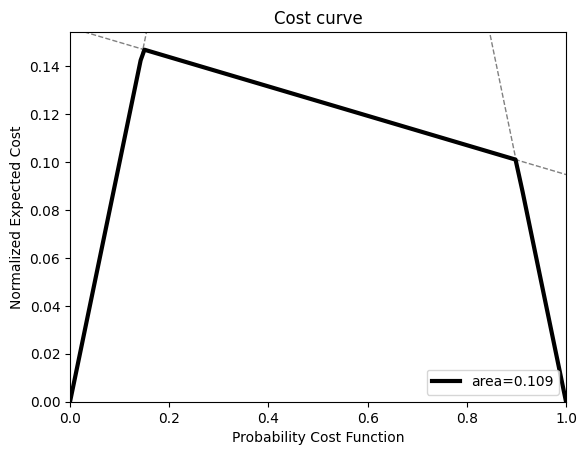

In [49]:
# C(-|+)
cost_fn_xgb = average_fn_xgb
# C(+|-)
cost_fp_xgb = average_fp_xgb

# Ground truth
truth = test_predictions_xgb['churn_encoded']
#  <a list of 0 (negative class) or 1 (positive class)>
# Predictions from a classifier
score = test_predictions_xgb['y_predicted']
# best_pipeline_log_reg.predict_proba(test.drop(y_encoded_col_name, axis=1))[:, 1]
# <a list of [0,1] class probabilities>

# %% OUTPUTS

# 1D-array of x-axis values (normalized PC)
pc = None
# list of lines as (slope, intercept)
lines = []
# lower envelope of the list of lines as a 1D-array of y-axis values (NEC)
lower_envelope = []
# area under the lower envelope (the smaller, the better)
area = None

# %% COMPUTATION

# points from the roc curve, because a point in the ROC space <=> a line in the cost space
roc_fpr, roc_tpr, _ = roc_curve(truth, score)

# compute the normalized p(+)*C(-|+)
thresholds = np.arange(0, 1.01, .01)
pc = (thresholds*cost_fn_xgb) / (thresholds*cost_fn_xgb + (1-thresholds)*cost_fp_xgb)

# compute a line in the cost space for each point in the roc space
for fpr, tpr in zip(roc_fpr, roc_tpr):
    slope = (1-tpr-fpr)
    intercept = fpr
    lines.append((slope, intercept))

# compute the lower envelope
for x_value in pc:
    y_value = min([slope*x_value+intercept for slope, intercept in lines])
    lower_envelope.append(max(0, y_value))
lower_envelope = np.array(lower_envelope)

# compute the area under the lower envelope using the composite trapezoidal rule
area = np.trapz(lower_envelope, pc)

# %% EXAMPLE OF PLOT

# display each line as a thin dashed line
for slope, intercept in lines:
    plt.plot(pc, slope*pc+intercept, color="grey", lw=1, linestyle="--")

# display the lower envelope as a thicker black line
plt.plot(pc, lower_envelope, color="black", lw=3, label="area={:.3f}".format(area))

# plot parameters
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05*max(lower_envelope)])
plt.xlabel("Probability Cost Function")
plt.ylabel("Normalized Expected Cost")
plt.title("Cost curve")
plt.legend(loc="lower right")

plt.show()

# from here on we calculate the amc, e-amc, mp and emp but with the fraud detection cost and benefit matrices

# total cost 50% decision threshold

In [50]:
test_predictions_log_fraud = test.copy(deep=True)
test_predictions_log_fraud["y_predicted"] = best_pipeline_log_reg.predict(test_predictions_log_fraud.drop(y, axis=1))
test_predictions_log_fraud["churn_encoded"] = fit_le.transform(test_predictions_log_fraud["churn"])

# first check if customers have multiple rows => if so check if we can take other if this instance-based cost
impute = SimpleImputer(strategy='median')
test_predictions_log_fraud['A'] = impute.fit_transform(
    (test_predictions_log["order_count"]*test_predictions_log["tenure"]*2000).to_frame())[:, 0]
# scaler = MinMaxScaler()

# Fit and transform the cb_cyolumn using the scaler
# test_predictions_log_fraud['A'] = scaler.fit_transform(test_predictions_log_fraud['A'].values.reshape(-1, 1))


# Step 3: Apply the function to calculate the cost for each instance and create the instance-dependent cost matrix
test_predictions_log_fraud['instance_cost'] = test_predictions_log_fraud.apply(lambda row: instance_dependent_cost_fraud(
    row['y_predicted'], row["churn_encoded"], row["A"]), axis=1)

test_predictions_log_fraud["y_predicted_decoded"] = fit_le.inverse_transform(
    test_predictions_log_fraud["y_predicted"])

# Print the DataFrame with the instance-dependent cost matrix
test_predictions_log_fraud[['churn', 'y_predicted_decoded', "A", 'instance_cost']]

print(f"Test cost/loss = {test_predictions_log_fraud['instance_cost'].sum():.0f}.")
print(' total cost/loss average : ' , test_predictions_log_fraud['instance_cost'].sum()/len(test_predictions_log_fraud))

Test cost/loss = 2574.
 total cost/loss average :  2.285968028419183


In [51]:
test_predictions_xgb_fraud = test.copy(deep=True)
test_predictions_xgb_fraud["y_predicted"] = best_pipeline_xgb.predict(test_predictions_xgb_fraud.drop(y, axis=1))
test_predictions_xgb_fraud["churn_encoded"] = fit_le.transform(test_predictions_xgb_fraud["churn"])

# first check if customers have multiple rows => if so check if we can take other if this instance-based cost
impute = SimpleImputer(strategy='median')
test_predictions_xgb_fraud['A'] = impute.fit_transform(
    (test_predictions_log["order_count"]*test_predictions_log["tenure"]*2000).to_frame())[:, 0]
# scaler = MinMaxScaler()

# Fit and transform the cb_column using the scaler
# test_predictions_xgb_fraud['A'] = scaler.fit_transform(test_predictions_xgb_fraud['A'].values.reshape(-1, 1))


# Step 3: Apply the function to calculate the cost for each instance and create the instance-dependent cost matrix
test_predictions_xgb_fraud['instance_cost'] = test_predictions_xgb_fraud.apply(lambda row: instance_dependent_cost_fraud(
    row['y_predicted'], row["churn_encoded"], row["A"]), axis=1)

test_predictions_xgb_fraud["y_predicted_decoded"] = fit_le.inverse_transform(
    test_predictions_xgb_fraud["y_predicted"])

# Print the DataFrame with the instance-dependent cost matrix
test_predictions_xgb_fraud[['churn', 'y_predicted_decoded', "A", 'instance_cost']]

print(f"Test cost/loss = {test_predictions_xgb_fraud['instance_cost'].sum():.0f}.")
print(' total cost/loss average : ' , test_predictions_xgb_fraud['instance_cost'].sum()/len(test_predictions_xgb_fraud))

Test cost/loss = 836.
 total cost/loss average :  0.7424511545293073


# amc-metric

Decision Threshold: 0.01, Test cost/loss = 827.00
Decision Threshold: 0.02, Test cost/loss = 798.00
Decision Threshold: 0.03, Test cost/loss = 777.00
Decision Threshold: 0.04, Test cost/loss = 816.00
Decision Threshold: 0.05, Test cost/loss = 1039.00
Decision Threshold: 0.06, Test cost/loss = 1198.00
Decision Threshold: 0.07, Test cost/loss = 1180.00
Decision Threshold: 0.08, Test cost/loss = 1348.00
Decision Threshold: 0.09, Test cost/loss = 1361.00
Decision Threshold: 0.10, Test cost/loss = 1358.00
Decision Threshold: 0.11, Test cost/loss = 1360.00
Decision Threshold: 0.12, Test cost/loss = 1415.00
Decision Threshold: 0.13, Test cost/loss = 1445.00
Decision Threshold: 0.14, Test cost/loss = 1455.00
Decision Threshold: 0.15, Test cost/loss = 1519.00
Decision Threshold: 0.16, Test cost/loss = 1664.00
Decision Threshold: 0.17, Test cost/loss = 1716.00
Decision Threshold: 0.18, Test cost/loss = 1733.00
Decision Threshold: 0.19, Test cost/loss = 1754.00
Decision Threshold: 0.20, Test cost

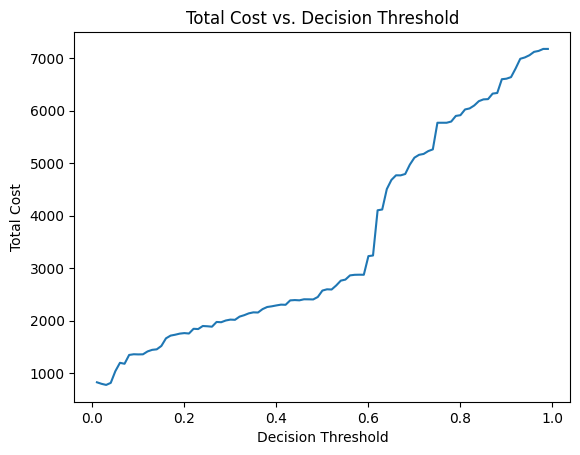

In [52]:
cb_column = 'A'
test_predictions_log_fraud['y_predicted_proba_log']= best_pipeline_log_reg.predict_proba(test_predictions_log_fraud.drop(y, axis=1))[:, 1]
best_threshold_log, AMC_log, lowest_cost_log = compute_best_threshold(test_predictions_log_fraud, best_pipeline_log_reg, y,cb_column,y_predicted_proba_col_name="y_predicted_proba_log", instance_dependent_cost_type = 'fraud' )

Decision Threshold: 0.01, Test cost/loss = 458.00
Decision Threshold: 0.02, Test cost/loss = 476.00
Decision Threshold: 0.03, Test cost/loss = 448.00
Decision Threshold: 0.04, Test cost/loss = 424.00
Decision Threshold: 0.05, Test cost/loss = 411.00
Decision Threshold: 0.06, Test cost/loss = 400.00
Decision Threshold: 0.07, Test cost/loss = 424.00
Decision Threshold: 0.08, Test cost/loss = 419.00
Decision Threshold: 0.09, Test cost/loss = 411.00
Decision Threshold: 0.10, Test cost/loss = 402.00
Decision Threshold: 0.11, Test cost/loss = 396.00
Decision Threshold: 0.12, Test cost/loss = 396.00
Decision Threshold: 0.13, Test cost/loss = 387.00
Decision Threshold: 0.14, Test cost/loss = 571.00
Decision Threshold: 0.15, Test cost/loss = 568.00
Decision Threshold: 0.16, Test cost/loss = 560.00
Decision Threshold: 0.17, Test cost/loss = 557.00
Decision Threshold: 0.18, Test cost/loss = 552.00
Decision Threshold: 0.19, Test cost/loss = 547.00
Decision Threshold: 0.20, Test cost/loss = 542.00


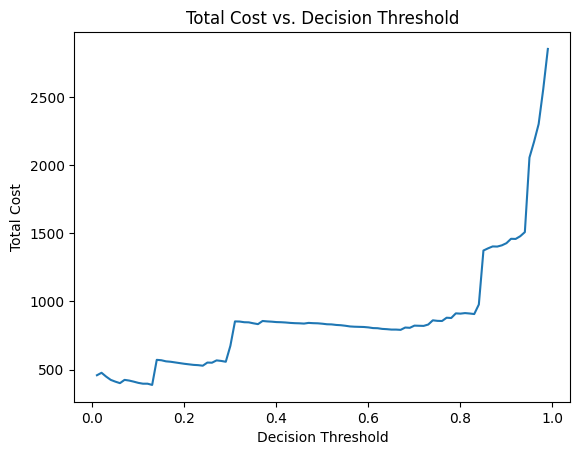

In [53]:
test_predictions_xgb_fraud['y_predicted_proba_xgb']= best_pipeline_xgb.predict_proba(test_predictions_xgb_fraud.drop(y, axis=1))[:, 1]
best_threshold_xgb, AMC_xgb, lowest_cost_xgb = compute_best_threshold(test_predictions_xgb_fraud, best_pipeline_xgb, y, cb_column, y_predicted_proba_col_name="y_predicted_proba_xgb", instance_dependent_cost_type = 'fraud')

# e-amc metric

In [54]:
test_predictions_log_fraud = add_eap_ep(
    train=train, 
    test=test_predictions_log_fraud, 
    y_col_name=y, 
    best_pipeline=best_pipeline_log_reg, 
    cb_column=cb_column, 
    predicted_proba_col_name='y_predicted_proba_log', 
    churn_label=1, 
    instance_dependent_cost_type="fraud")
test_predictions_xgb_fraud = add_eap_ep(
    train=train, 
    test=test_predictions_xgb_fraud, 
    y_col_name=y, 
    best_pipeline=best_pipeline_xgb, 
    cb_column=cb_column, 
    predicted_proba_col_name="y_predicted_proba_xgb", 
    churn_label=1, 
    instance_dependent_cost_type="fraud")

c:\Users\stijn\OneDrive\Bureaublad\TEW 1ste jaar\python thesis\End-to-end-project---Customer-churn\notebooks\..\src\common_functions.py:329: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_actual_label_0['EAP'] = test_actual_label_0[predicted_proba_col_name]*test_actual_label_0['FP'] + \
c:\Users\stijn\OneDrive\Bureaublad\TEW 1ste jaar\python thesis\End-to-end-project---Customer-churn\notebooks\..\src\common_functions.py:331: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_actual_label_0['EP'] = estim

In [55]:
print(test_predictions_log_fraud['EAP'].sum())
print(test_predictions_log_fraud['EP'].sum())


print('EAP : ', test_predictions_log_fraud['EAP'].sum()/len(test_predictions_log_fraud))
print('EP : ', test_predictions_log_fraud['EP'].sum()/len(test_predictions_log_fraud))

3499.3068503272293
6125.840142095914
EAP :  3.1077325491360828
EP :  5.440355365982162


In [56]:
print(test_predictions_xgb_fraud['EAP'].sum())
print(test_predictions_xgb_fraud['EP'].sum())


print('EAP : ', test_predictions_xgb_fraud['EAP'].sum()/len(test_predictions_xgb_fraud))
print('EP : ', test_predictions_xgb_fraud['EP'].sum()/len(test_predictions_xgb_fraud))

892.2428172531784
6125.840142095914
EAP :  0.7924003705623254
EP :  5.440355365982162


# MP at 50% threshold

In [57]:
test_predictions_log_fraud_2 = test.copy(deep=True)
test_predictions_log_fraud_2["y_predicted"] = best_pipeline_log_reg.predict(test_predictions_log_fraud_2.drop(y, axis=1))
test_predictions_log_fraud_2["churn_encoded"] = fit_le.transform(test_predictions_log_fraud_2["churn"])

# first check if customers have multiple rows => if so check if we can take other if this instance-based cost
impute = SimpleImputer(strategy='median')
test_predictions_log_fraud_2['A'] = impute.fit_transform(
    (test_predictions_log["order_count"]*test_predictions_log["tenure"]*2000).to_frame())[:, 0]
# scaler = MinMaxScaler()

# Fit and transform the cb_cyolumn using the scaler
# test_predictions_log_fraud_2['A'] = scaler.fit_transform(test_predictions_log_fraud_2['A'].values.reshape(-1, 1))


# Step 3: Apply the function to calculate the cost for each instance and create the instance-dependent cost matrix
test_predictions_log_fraud_2['instance_cost'] = test_predictions_log_fraud_2.apply(lambda row: instance_dependent_cost_fraud_2(
    row['y_predicted'], row["churn_encoded"], row["A"]), axis=1)

test_predictions_log_fraud_2["y_predicted_decoded"] = fit_le.inverse_transform(
    test_predictions_log_fraud_2["y_predicted"])

# Print the DataFrame with the instance-dependent cost matrix
test_predictions_log_fraud_2[['churn', 'y_predicted_decoded', "A", 'instance_cost']]

print(f"Test cost/loss = {test_predictions_log_fraud_2['instance_cost'].sum():.0f}.")
print(' total cost/loss average : ' , test_predictions_log_fraud_2['instance_cost'].sum()/len(test_predictions_log_fraud_2))

Test cost/loss = -2466.
 total cost/loss average :  -2.1900532859680286


In [58]:
test_predictions_xgb_fraud_2 = test.copy(deep=True)
test_predictions_xgb_fraud_2["y_predicted"] = best_pipeline_xgb.predict(test_predictions_xgb_fraud_2.drop(y, axis=1))
test_predictions_xgb_fraud_2["churn_encoded"] = fit_le.transform(test_predictions_xgb_fraud_2["churn"])

# first check if customers have multiple rows => if so check if we can take other if this instance-based cost
impute = SimpleImputer(strategy='median')
test_predictions_xgb_fraud_2['A'] = impute.fit_transform(
    (test_predictions_log["order_count"]*test_predictions_log["tenure"]*2000).to_frame())[:, 0]
# scaler = MinMaxScaler()

# Fit and transform the cb_column using the scaler
# test_predictions_xgb_fraud_2['A'] = scaler.fit_transform(test_predictions_xgb_fraud_2['A'].values.reshape(-1, 1))


# Step 3: Apply the function to calculate the cost for each instance and create the instance-dependent cost matrix
test_predictions_xgb_fraud_2['instance_cost'] = test_predictions_xgb_fraud_2.apply(lambda row: instance_dependent_cost_fraud_2(
    row['y_predicted'], row["churn_encoded"], row["A"]), axis=1)

test_predictions_xgb_fraud_2["y_predicted_decoded"] = fit_le.inverse_transform(
    test_predictions_xgb_fraud_2["y_predicted"])

# Print the DataFrame with the instance-dependent cost matrix
test_predictions_xgb_fraud_2[['churn', 'y_predicted_decoded', "A", 'instance_cost']]

print(f"Test cost/loss = {test_predictions_xgb_fraud_2['instance_cost'].sum():.0f}.")
print(' total cost/loss average : ' , test_predictions_xgb_fraud_2['instance_cost'].sum()/len(test_predictions_xgb_fraud_2))

Test cost/loss = -664.
 total cost/loss average :  -0.5896980461811723


# MP metric

Decision Threshold: 0.01, Test cost/loss = -642.00
Decision Threshold: 0.02, Test cost/loss = -619.00
Decision Threshold: 0.03, Test cost/loss = -601.00
Decision Threshold: 0.04, Test cost/loss = -643.00
Decision Threshold: 0.05, Test cost/loss = -871.00
Decision Threshold: 0.06, Test cost/loss = -1031.00
Decision Threshold: 0.07, Test cost/loss = -1013.00
Decision Threshold: 0.08, Test cost/loss = -1182.00
Decision Threshold: 0.09, Test cost/loss = -1199.00
Decision Threshold: 0.10, Test cost/loss = -1197.00
Decision Threshold: 0.11, Test cost/loss = -1200.00
Decision Threshold: 0.12, Test cost/loss = -1256.00
Decision Threshold: 0.13, Test cost/loss = -1289.00
Decision Threshold: 0.14, Test cost/loss = -1300.00
Decision Threshold: 0.15, Test cost/loss = -1366.00
Decision Threshold: 0.16, Test cost/loss = -1512.00
Decision Threshold: 0.17, Test cost/loss = -1566.00
Decision Threshold: 0.18, Test cost/loss = -1585.00
Decision Threshold: 0.19, Test cost/loss = -1607.00
Decision Threshol

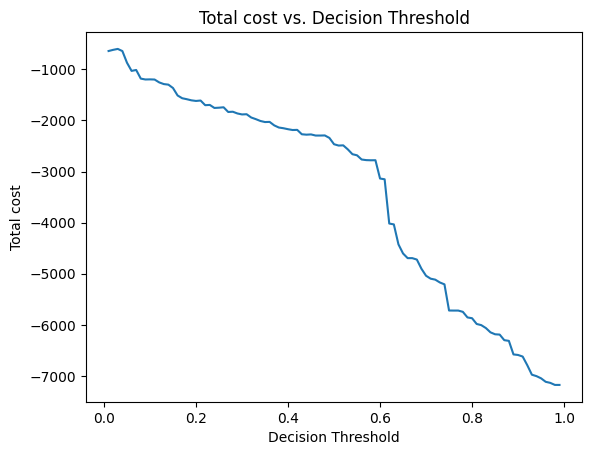

In [59]:
cb_column = 'A'
test_predictions_log_fraud_2['y_predicted_proba_log']= best_pipeline_log_reg.predict_proba(test_predictions_log_fraud_2.drop(y, axis=1))[:, 1]
best_threshold_log, AMC_log, lowest_cost_log = compute_best_threshold_2(test_predictions_log_fraud_2, best_pipeline_log_reg, y,cb_column,y_predicted_proba_col_name="y_predicted_proba_log", instance_dependent_cost_type = 'fraud_2' )

Decision Threshold: 0.01, Test cost/loss = -270.00
Decision Threshold: 0.02, Test cost/loss = -291.00
Decision Threshold: 0.03, Test cost/loss = -263.00
Decision Threshold: 0.04, Test cost/loss = -239.00
Decision Threshold: 0.05, Test cost/loss = -226.00
Decision Threshold: 0.06, Test cost/loss = -215.00
Decision Threshold: 0.07, Test cost/loss = -241.00
Decision Threshold: 0.08, Test cost/loss = -236.00
Decision Threshold: 0.09, Test cost/loss = -228.00
Decision Threshold: 0.10, Test cost/loss = -220.00
Decision Threshold: 0.11, Test cost/loss = -214.00
Decision Threshold: 0.12, Test cost/loss = -214.00
Decision Threshold: 0.13, Test cost/loss = -205.00
Decision Threshold: 0.14, Test cost/loss = -390.00
Decision Threshold: 0.15, Test cost/loss = -387.00
Decision Threshold: 0.16, Test cost/loss = -379.00
Decision Threshold: 0.17, Test cost/loss = -376.00
Decision Threshold: 0.18, Test cost/loss = -371.00
Decision Threshold: 0.19, Test cost/loss = -366.00
Decision Threshold: 0.20, Test 

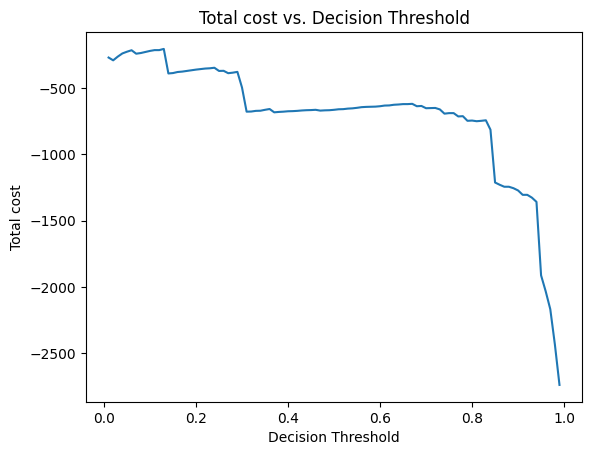

In [60]:
test_predictions_xgb_fraud_2['y_predicted_proba_xgb']= best_pipeline_xgb.predict_proba(test_predictions_xgb_fraud_2.drop(y, axis=1))[:, 1]
best_threshold_xgb, AMC_xgb, lowest_cost_xgb = compute_best_threshold_2(test_predictions_xgb_fraud_2, best_pipeline_xgb, y, cb_column, y_predicted_proba_col_name="y_predicted_proba_xgb", instance_dependent_cost_type = 'fraud_2')

# EMP metric

In [61]:
test_predictions_log_fraud_2 = add_eap_ep(
    train=train, 
    test=test_predictions_log_fraud_2, 
    y_col_name=y, 
    best_pipeline=best_pipeline_log_reg, 
    cb_column=cb_column, 
    predicted_proba_col_name='y_predicted_proba_log', 
    churn_label=1, 
    instance_dependent_cost_type="fraud_2")
test_predictions_xgb_fraud_2 = add_eap_ep(
    train=train, 
    test=test_predictions_xgb_fraud_2, 
    y_col_name=y, 
    best_pipeline=best_pipeline_xgb, 
    cb_column=cb_column, 
    predicted_proba_col_name="y_predicted_proba_xgb", 
    churn_label=1, 
    instance_dependent_cost_type="fraud_2")

c:\Users\stijn\OneDrive\Bureaublad\TEW 1ste jaar\python thesis\End-to-end-project---Customer-churn\notebooks\..\src\common_functions.py:329: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_actual_label_0['EAP'] = test_actual_label_0[predicted_proba_col_name]*test_actual_label_0['FP'] + \
c:\Users\stijn\OneDrive\Bureaublad\TEW 1ste jaar\python thesis\End-to-end-project---Customer-churn\notebooks\..\src\common_functions.py:331: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_actual_label_0['EP'] = estim

In [62]:
print(test_predictions_log_fraud_2['EAP'].sum())
print(test_predictions_log_fraud_2['EP'].sum())


print('EAP : ', test_predictions_log_fraud_2['EAP'].sum()/len(test_predictions_log_fraud_2))
print('EP : ', test_predictions_log_fraud_2['EP'].sum()/len(test_predictions_log_fraud_2))

-3401.3379263116963
-6093.864120781528
EAP :  -3.0207263999215774
EP :  -5.411957478491588


In [63]:
print(test_predictions_xgb_fraud_2['EAP'].sum())
print(test_predictions_xgb_fraud_2['EP'].sum())


print('EAP : ', test_predictions_xgb_fraud_2['EAP'].sum()/len(test_predictions_xgb_fraud_2))
print('EP : ', test_predictions_xgb_fraud_2['EP'].sum()/len(test_predictions_xgb_fraud_2))

-721.9637915776437
-6093.864120781528
EAP :  -0.6411756585947103
EP :  -5.411957478491588


# cost curves

In [64]:
total_fp_log_2 = 0

for i in range(0,1126):
    if test_predictions_log_fraud['churn_encoded'].iloc[i] == 0 and test_predictions_log_fraud['y_predicted'].iloc[i]==1:
        total_fp_log_2 += test_predictions_log_fraud['FP'].iloc[i]
    else:
        total_fp_log_2 += 0

print(total_fp_log_2)

average_fp_log_2 = total_fp_log_2/1126
print( average_fp_log_2)

36
0.03197158081705151


In [65]:
total_fn_log_2 = 0

for i in range(0,1126):
    if test_predictions_log_fraud['churn_encoded'].iloc[i] == 1 and test_predictions_log_fraud['y_predicted'].iloc[i]==0:
        total_fn_log_2 += test_predictions_log_fraud['FN'].iloc[i]
    else:
        total_fn_log_2 += 0

print(total_fn_log_2)

average_fn_log_2 = total_fn_log_2/1126
print( average_fn_log_2)

2538.0
2.2539964476021312


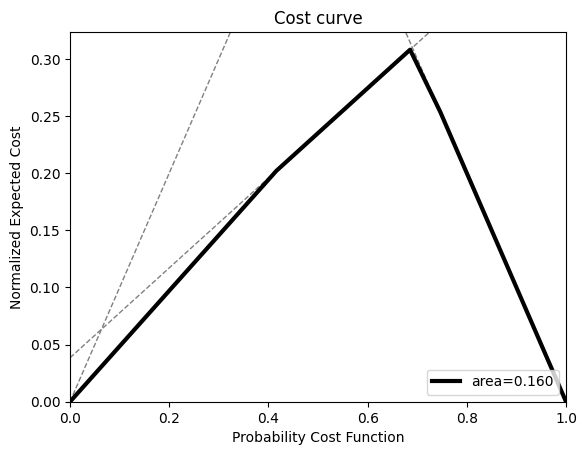

In [66]:
cost_fn_log_2 = average_fn_log_2
# C(+|-)
cost_fp_log_2 = average_fp_log_2

# Ground truth
truth = test_predictions_log_fraud['churn_encoded']
#  <a list of 0 (negative class) or 1 (positive class)>
# Predictions from a classifier
score = test_predictions_log_fraud['y_predicted']
# best_pipeline_log_reg.predict_proba(test.drop(y_encoded_col_name, axis=1))[:, 1]
# <a list of [0,1] class probabilities>

# %% OUTPUTS

# 1D-array of x-axis values (normalized PC)
pc = None
# list of lines as (slope, intercept)
lines = []
# lower envelope of the list of lines as a 1D-array of y-axis values (NEC)
lower_envelope = []
# area under the lower envelope (the smaller, the better)
area = None

# %% COMPUTATION

# points from the roc curve, because a point in the ROC space <=> a line in the cost space
roc_fpr, roc_tpr, _ = roc_curve(truth, score)

# compute the normalized p(+)*C(-|+)
thresholds = np.arange(0, 1.01, .01)
pc = (thresholds*cost_fn_log_2) / (thresholds*cost_fn_log_2 + (1-thresholds)*cost_fp_log_2)

# compute a line in the cost space for each point in the roc space
for fpr, tpr in zip(roc_fpr, roc_tpr):
    slope = (1-tpr-fpr)
    intercept = fpr
    lines.append((slope, intercept))

# compute the lower envelope
for x_value in pc:
    y_value = min([slope*x_value+intercept for slope, intercept in lines])
    lower_envelope.append(max(0, y_value))
lower_envelope = np.array(lower_envelope)

# compute the area under the lower envelope using the composite trapezoidal rule
area = np.trapz(lower_envelope, pc)

# %% EXAMPLE OF PLOT

# display each line as a thin dashed line
for slope, intercept in lines:
    plt.plot(pc, slope*pc+intercept, color="grey", lw=1, linestyle="--")

# display the lower envelope as a thicker black line
plt.plot(pc, lower_envelope, color="black", lw=3, label="area={:.3f}".format(area))

# plot parameters
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05*max(lower_envelope)])
plt.xlabel("Probability Cost Function")
plt.ylabel("Normalized Expected Cost")
plt.title("Cost curve")
plt.legend(loc="lower right")

plt.show()

In [67]:
total_fp_xgb_2 = 0

for i in range(0,1126):
    if test_predictions_xgb_fraud['churn_encoded'].iloc[i] == 0 and test_predictions_xgb_fraud['y_predicted'].iloc[i]==1:
        total_fp_xgb_2 += test_predictions_xgb_fraud['FP'].iloc[i]
    else:
        total_fp_xgb_2 += 0

print(total_fp_xgb_2)

average_fp_xgb_2 = total_fp_xgb_2/1126
print( average_fp_xgb_2)

146
0.12966252220248667


In [68]:
total_fn_xgb_2 = 0

for i in range(0,1126):
    if test_predictions_xgb_fraud['churn_encoded'].iloc[i] == 1 and test_predictions_xgb_fraud['y_predicted'].iloc[i]==0:
        total_fn_xgb_2 += test_predictions_xgb_fraud['FN'].iloc[i]
    else:
        total_fn_xgb_2 += 0

print(total_fn_xgb_2)

average_fn_xgb_2 = total_fn_xgb_2/1126
print( average_fn_xgb_2)

690.0
0.6127886323268206


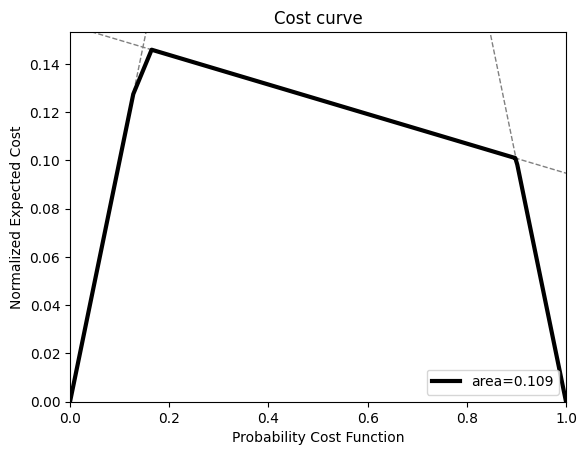

In [69]:
#C(-|+)
cost_fn_xgb_2 = average_fn_xgb_2
# C(+|-)
cost_fp_xgb_2 = average_fp_xgb_2

# Ground truth
truth = test_predictions_xgb_fraud['churn_encoded']
#  <a list of 0 (negative class) or 1 (positive class)>
# Predictions from a classifier
score = test_predictions_xgb_fraud['y_predicted']
# best_pipeline_log_reg.predict_proba(test.drop(y_encoded_col_name, axis=1))[:, 1]
# <a list of [0,1] class probabilities>

# %% OUTPUTS

# 1D-array of x-axis values (normalized PC)
pc = None
# list of lines as (slope, intercept)
lines = []
# lower envelope of the list of lines as a 1D-array of y-axis values (NEC)
lower_envelope = []
# area under the lower envelope (the smaller, the better)
area = None

# %% COMPUTATION

# points from the roc curve, because a point in the ROC space <=> a line in the cost space
roc_fpr, roc_tpr, _ = roc_curve(truth, score)

# compute the normalized p(+)*C(-|+)
thresholds = np.arange(0, 1.01, .01)
pc = (thresholds*cost_fn_xgb_2) / (thresholds*cost_fn_xgb_2 + (1-thresholds)*cost_fp_xgb_2)

# compute a line in the cost space for each point in the roc space
for fpr, tpr in zip(roc_fpr, roc_tpr):
    slope = (1-tpr-fpr)
    intercept = fpr
    lines.append((slope, intercept))

# compute the lower envelope
for x_value in pc:
    y_value = min([slope*x_value+intercept for slope, intercept in lines])
    lower_envelope.append(max(0, y_value))
lower_envelope = np.array(lower_envelope)

# compute the area under the lower envelope using the composite trapezoidal rule
area = np.trapz(lower_envelope, pc)

# %% EXAMPLE OF PLOT

# display each line as a thin dashed line
for slope, intercept in lines:
    plt.plot(pc, slope*pc+intercept, color="grey", lw=1, linestyle="--")

# display the lower envelope as a thicker black line
plt.plot(pc, lower_envelope, color="black", lw=3, label="area={:.3f}".format(area))

# plot parameters
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05*max(lower_envelope)])
plt.xlabel("Probability Cost Function")
plt.ylabel("Normalized Expected Cost")
plt.title("Cost curve")
plt.legend(loc="lower right")

plt.show()